In [1]:
%reset -f
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
from torch import device as torch_device

#devices = [torch_device('cuda', i) for i in range(torch.cuda.device_count())] + [torch_device('cpu')]
#print(devices)
desired_gpu_index = 1
device = torch.device(f'cuda:{desired_gpu_index}')
device

__Python VERSION: 3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
__pyTorch VERSION: 2.0.1
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
__CUDNN VERSION: 8700
__Number CUDA Devices: 2
__Devices
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA A100-PCIE-40GB, 525.125.06, 40960 MiB, 39522 MiB, 814 MiB
1, NVIDIA A100 80GB PCIe, 525.125.06, 81920 MiB, 31856 MiB, 49195 MiB
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


device(type='cuda', index=1)

In [2]:
import os
from unet_parts import *
from unet_parts_att_transformer import *
from unet_parts_att_multiscale import *
from transformerskip import tskip
import random
random.seed(20)
np.random.seed(20)
torch.manual_seed(20)
torch.cuda.manual_seed(20)

In [3]:
torch.cuda.device_count()

2

In [4]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage


In [5]:
from torchmetrics import Dice
import torch.optim as optim

In [6]:
# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         intersection = (inputs * targets).sum()                            
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
#         return 1 - dice
# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         intersection = (inputs * targets).sum()                            
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
#         return 1 - dice
def dice_loss(pred, target):
    smooth = 1.#1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice
def dice_coeff(pred, target):
    smooth = 1.#1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


# def dice_loss(pred, target):
#     smooth = 1.#1e-5
#     intersection = (pred * target).sum()
#     union = pred.sum() + target.sum()
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1 - dice
# def dice_coeff(pred, target):
#     smooth = 1.#1e-5
#     intersection = (pred * target).sum()
#     union = pred.sum() + target.sum()
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return dice

In [7]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import albumentations as A
import time
from tqdm.notebook import tqdm
from torchsummary import summary




In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# Define custom dataset class

def parse_image(img_path, image_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img ,image_size, interpolation = cv2.INTER_CUBIC)
    img = img.astype(np.float32)
    mn = np.amin(img)
    mx = np.amax(img)
    d = mx - mn
    img = (img-mn)/d
    #print(np.amax(img),np.amin(img))
    img = ToTensor()(img)
    #img = np.expand_dims(img, axis=2)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(img_path, image_size):
    mask_path = "/home/rabeea/Kvasir/masks/" + img_path.split('/')[-1]
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.where(mask>50,255,0)
    mask = cv2.resize(mask.astype(np.uint8),image_size, interpolation = cv2.INTER_NEAREST)
    #mask = np.expand_dims(mask, axis=2)
    mask = mask.astype(np.uint8)
    mask = np.where(mask>0,1,mask)
    mask = torch.from_numpy(mask).long()
    return mask

class DataGen(Dataset):
    def __init__(self, image_size, images_path , transform=None):
        self.image_size = image_size
        self.images_path = images_path
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        image = parse_image(self.images_path[index], self.image_size)
        mask = parse_mask(self.images_path[index], self.image_size)

        if self.transform is not None:
            image = self.transform(image)

        return image, mask


In [9]:
imgpath = glob.glob("/home/rabeea/Kvasir/images/*.jpg", recursive = True)
print(len(imgpath))

1000


In [10]:
tr = 700
val = 100
ts = 200
imgpath = sorted(imgpath)
random.Random(42).shuffle(imgpath)
trainpath = imgpath[:tr]
valpath = imgpath[tr:tr+val]
testpath = imgpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))

1000 700 100 200


In [11]:
image_size = (256,256)
batch_size = 1

epochs = 200

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath)
val_gen = DataGen(image_size,valpath)
test_gen = DataGen(image_size,testpath)

train_loader = DataLoader(train_gen, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_gen, batch_size=batch_size, shuffle=False)  
test_loader = DataLoader(test_gen, batch_size=1, shuffle=False) 

Feature batch shape: torch.Size([1, 1, 256, 256])
Labels batch shape: torch.Size([1, 256, 256])


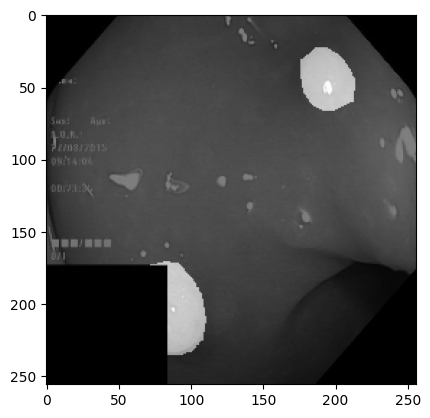

In [12]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.imshow(label, 'gray', alpha=0.5)

In [13]:
np.unique(label)

array([0, 1])

In [14]:
img.dtype

torch.float32

In [16]:
class UNet_Attention_Transformer_Multiscale(nn.Module):
    def __init__(self, n_channels = 1, n_classes=1, bilinear=True):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.edown = Down(512,1024)
        factor = 2 if bilinear else 1
        self.down4 = Down(1024, 2048 // factor)
        self.eup = Up(2048, 1024 // factor, bilinear)
        self.up1 = Up(2048, 512 // factor, bilinear)
        self.up2 = Up(1024, 256 // factor, bilinear)
        self.up3 = Up(512, 128 // factor, bilinear)
        self.up4 = Up(256, 64, bilinear)
        self.outc = OutConv(128, n_classes)

        
#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         self.down3 = Down(256, 512)
#         factor = 2 if bilinear else 1
#         self.down4 = Down(512, 1024 // factor)
#         self.up1 = Up(1024, 512 // factor, bilinear)
#         self.up2 = Up(1024, 256 // factor, bilinear)
#         self.up3 = Up(512, 128 // factor, bilinear)
#         self.up4 = Up(256, 64, bilinear)
#         self.outc = OutConv(128, n_classes)

        '''位置编码'''
        self.pos = PositionEmbeddingLearned(1024 // factor)
        #self.pos = PositionEmbeddingLearned(512 // factor)

        '''空间注意力机制'''
        self.pam = PAM_Module(1024)

        '''自注意力机制'''
        self.sdpa = ScaledDotProductAttention(512)

        '''残差多尺度连接'''
#         self.fuse1 = MultiConv(768, 256)
#         self.fuse2 = MultiConv(384, 128)
#         self.fuse3 = MultiConv(192, 64)
#         self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        xe = self.edown(x4)
        x5 = self.down4(xe)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        #[x1,x2,x3,x4] = tskip([x1,x2,x3,x4],device = device, up=4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        
        
        '''Setting 1'''
        x5_pam = self.pam(x5)

        '''Setting 2'''
        x5_pos = self.pos(x5)
        x5 = x5 + x5_pos


        x5_sdpa = self.sdpa(x5)
        x5 = x5_sdpa + x5_pam
        
        xee = self.eup(x5, xe)
        xe_scale = F.interpolate(x5, size=xee.shape[2:], mode='bilinear', align_corners=True)
        xee_cat = torch.cat((xe_scale, xee), 1)

        x6 = self.up1(xee_cat, x4)
        x5_scale = F.interpolate(xee, size=x6.shape[2:], mode='bilinear', align_corners=True)
        x6_cat = torch.cat((x5_scale, x6), 1)

        x7 = self.up2(x6_cat, x3)
        x6_scale = F.interpolate(x6, size=x7.shape[2:], mode='bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        x8 = self.up3(x7_cat, x2)
        x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
        x8_cat = torch.cat((x7_scale, x8), 1)

        x9 = self.up4(x8_cat, x1)
        x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
        x9 = torch.cat((x8_scale, x9), 1)

        logits = self.outc(x9)
        return logits


In [15]:
class UNet_Attention_Transformer_Multiscale(nn.Module):
    def __init__(self, n_channels = 1, n_classes=1, bilinear=True):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        factor = 2 if bilinear else 1
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(512, 128 // factor, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.outc = OutConv(128, n_classes)
        

        '''位置编码'''
        self.pos = PositionEmbeddingLearned(256 // factor)
        #self.pos = PositionEmbeddingLearned(512 // factor)

        '''空间注意力机制'''
        self.pam = PAM_Module(256)

        '''自注意力机制'''
        self.sdpa = ScaledDotProductAttention(256)

        '''残差多尺度连接'''
#         self.fuse1 = MultiConv(768, 256)
#         self.fuse2 = MultiConv(384, 128)
#         self.fuse3 = MultiConv(192, 64)
#         self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        #[x1,x2,x3,x4] = tskip([x1,x2,x3,x4],device = device, up=4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        
        
        '''Setting 1'''
        x4_pam = self.pam(x4)

        '''Setting 2'''
        x4_pos = self.pos(x4)
        x4 = x4 + x4_pos


        x4_sdpa = self.sdpa(x4)
        x4 = x4_sdpa + x4_pam
        

#         x6 = self.up1(x5, x4)
#         x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
#         x6_cat = torch.cat((x5_scale, x6), 1)

        x7 = self.up1(x4, x3)
        x6_scale = F.interpolate(x4, size=x7.shape[2:], mode='bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        x8 = self.up2(x7_cat, x2)
        x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
        x8_cat = torch.cat((x7_scale, x8), 1)

        x9 = self.up3(x8_cat, x1)
        x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
        x9 = torch.cat((x8_scale, x9), 1)

        logits = self.outc(x9)
        return logits


In [14]:
class UNet_Attention_Transformer_Multiscale(nn.Module):
    def __init__(self, n_channels = 1, n_classes=1, bilinear=True):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 128)
        self.down1 = Down(128, 256)
        self.down2 = Down(256, 512)
        self.down3 = Down(512, 1024)
        factor = 2 if bilinear else 1
        self.down4 = Down(1024, 2048 // factor)
        self.up1 = Up(2048, 1024 // factor, bilinear)
        self.up2 = Up(2048, 512 // factor, bilinear)
        self.up3 = Up(1024, 256 // factor, bilinear)
        self.up4 = Up(512, 128, bilinear)
        self.outc = OutConv(256, n_classes)

        
#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         self.down3 = Down(256, 512)
#         factor = 2 if bilinear else 1
#         self.down4 = Down(512, 1024 // factor)
#         self.up1 = Up(1024, 512 // factor, bilinear)
#         self.up2 = Up(1024, 256 // factor, bilinear)
#         self.up3 = Up(512, 128 // factor, bilinear)
#         self.up4 = Up(256, 64, bilinear)
#         self.outc = OutConv(128, n_classes)

        '''位置编码'''
        self.pos = PositionEmbeddingLearned(1024 // factor)
        #self.pos = PositionEmbeddingLearned(512 // factor)

        '''空间注意力机制'''
        self.pam = PAM_Module(1024)

        '''自注意力机制'''
        self.sdpa = ScaledDotProductAttention(1024)

        '''残差多尺度连接'''
#         self.fuse1 = MultiConv(768, 256)
#         self.fuse2 = MultiConv(384, 128)
#         self.fuse3 = MultiConv(192, 64)
#         self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        #[x1,x2,x3,x4] = tskip([x1,x2,x3,x4],device = device, up=4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        

        '''Setting 1'''
        x5_pam = self.pam(x5)
        '''Setting 2'''
        x5_pos = self.pos(x5)
        x5 = x5 + x5_pos


        x5_sdpa = self.sdpa(x5)
        x5 = x5_sdpa + x5_pam
        
        x6 = self.up1(x5, x4)
        x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
        x6_cat = torch.cat((x5_scale, x6), 1)

        x7 = self.up2(x6_cat, x3)
        x6_scale = F.interpolate(x6, size=x7.shape[2:], mode='bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        x8 = self.up3(x7_cat, x2)
        x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
        x8_cat = torch.cat((x7_scale, x8), 1)

        x9 = self.up4(x8_cat, x1)
        x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
        x9 = torch.cat((x8_scale, x9), 1)

        logits = self.outc(x9)
        return logits


In [14]:
class UNet_Attention_Transformer_Multiscale(nn.Module):
    def __init__(self, n_channels = 1, n_classes=1, bilinear=True):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 256)
        self.down1 = Down(256, 512)
        self.down2 = Down(512, 1024)
        self.down3 = Down(1024, 2048)
        factor = 2 if bilinear else 1
        self.down4 = Down(2048, 4096 // factor)
        self.up1 = Up(4096, 2048 // factor, bilinear)
        self.up2 = Up(4096, 1024 // factor, bilinear)
        self.up3 = Up(2048, 512 // factor, bilinear)
        self.up4 = Up(1024, 256, bilinear)
        self.outc = OutConv(512, n_classes)
        
#         self.inc = DoubleConv(n_channels, 128)
#         self.down1 = Down(128, 256)
#         self.down2 = Down(256, 512)
#         self.down3 = Down(512, 1024)
#         factor = 2 if bilinear else 1
#         self.down4 = Down(1024, 2048 // factor)
#         self.up1 = Up(2048, 1024 // factor, bilinear)
#         self.up2 = Up(2048, 512 // factor, bilinear)
#         self.up3 = Up(1024, 256 // factor, bilinear)
#         self.up4 = Up(512, 128, bilinear)
#         self.outc = OutConv(256, n_classes)

        
#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         self.down3 = Down(256, 512)
#         factor = 2 if bilinear else 1
#         self.down4 = Down(512, 1024 // factor)
#         self.up1 = Up(1024, 512 // factor, bilinear)
#         self.up2 = Up(1024, 256 // factor, bilinear)
#         self.up3 = Up(512, 128 // factor, bilinear)
#         self.up4 = Up(256, 64, bilinear)
#         self.outc = OutConv(128, n_classes)

        '''位置编码'''
        self.pos = PositionEmbeddingLearned(2048 // factor)
        #self.pos = PositionEmbeddingLearned(512 // factor)

        '''空间注意力机制'''
        self.pam = PAM_Module(2048)

        '''自注意力机制'''
        self.sdpa = ScaledDotProductAttention(2048)

        '''残差多尺度连接'''
#         self.fuse1 = MultiConv(768, 256)
#         self.fuse2 = MultiConv(384, 128)
#         self.fuse3 = MultiConv(192, 64)
#         self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        #[x1,x2,x3,x4] = tskip([x1,x2,x3,x4],device = device, up=4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        

        '''Setting 1'''
        x5_pam = self.pam(x5)
        '''Setting 2'''
        x5_pos = self.pos(x5)
        x5 = x5 + x5_pos


        x5_sdpa = self.sdpa(x5)
        x5 = x5_sdpa + x5_pam
        
        x6 = self.up1(x5, x4)
        x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
        x6_cat = torch.cat((x5_scale, x6), 1)

        x7 = self.up2(x6_cat, x3)
        x6_scale = F.interpolate(x6, size=x7.shape[2:], mode='bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        x8 = self.up3(x7_cat, x2)
        x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
        x8_cat = torch.cat((x7_scale, x8), 1)

        x9 = self.up4(x8_cat, x1)
        x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
        x9 = torch.cat((x8_scale, x9), 1)

        logits = self.outc(x9)
        return logits


# new

In [15]:
class UNet_Attention_Transformer_Multiscale(nn.Module):
    def __init__(self, n_channels = 1, n_classes=1, bilinear=True):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        factor = 2 if bilinear else 1
        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128 // factor)
        self.up1 = Up(128, 64 // factor, bilinear)
        self.up2 = Up(128, 32 // factor, bilinear)
        self.up3 = Up(64, 16, bilinear)
        self.outc = OutConv(32, n_classes)
        

        '''位置编码'''
        self.pos = PositionEmbeddingLearned(64// factor)
        #self.pos = PositionEmbeddingLearned(512 // factor)

        '''空间注意力机制'''
        self.pam = PAM_Module(64)

        '''自注意力机制'''
        self.sdpa = ScaledDotProductAttention(64)

        '''残差多尺度连接'''
#         self.fuse1 = MultiConv(768, 256)
#         self.fuse2 = MultiConv(384, 128)
#         self.fuse3 = MultiConv(192, 64)
#         self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        #[x1,x2,x3,x4] = tskip([x1,x2,x3,x4],device = device, up=4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        
        
        '''Setting 1'''
        x4_pam = self.pam(x4)

        '''Setting 2'''
        x4_pos = self.pos(x4)
        x4 = x4 + x4_pos


        x4_sdpa = self.sdpa(x4)
        x4 = x4_sdpa + x4_pam
        

#         x6 = self.up1(x5, x4)
#         x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
#         x6_cat = torch.cat((x5_scale, x6), 1)

        x7 = self.up1(x4, x3)
        x6_scale = F.interpolate(x4, size=x7.shape[2:], mode='bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        x8 = self.up2(x7_cat, x2)
        x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
        x8_cat = torch.cat((x7_scale, x8), 1)

        x9 = self.up3(x8_cat, x1)
        x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
        x9 = torch.cat((x8_scale, x9), 1)

        logits = self.outc(x9)
        return logits


In [16]:
model = UNet_Attention_Transformer_Multiscale()

In [17]:
model

UNet_Attention_Transformer_Multiscale(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): Batch

In [18]:
epochs = 200

In [19]:
model.to(device)

UNet_Attention_Transformer_Multiscale(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): Batch

In [20]:
filename_sd = '/home/rabeea/logs/TransAttUnet_polyp/TransAttUNet_polyp_16_msa512_ly4_lr3.pth'

In [21]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)#, momentum=0.9)
torch.cuda.empty_cache()
max_dice = 0
train_losses = []
test_losses = []
train_dices = []
val_dices = []
decrease = 1  
fit_time = time.time()
not_improve=0
for epoch in range(epochs):
    # Your dataset or data loading logic goes here
    since = time.time()
    # Training
    model.train()
    train_loss = 0
    train_dice = 0
    num_batches = 0
    
    for i,data in enumerate(tqdm(train_loader)):  # Replace train_loader with your data loader
        inputs, labels = data
        # Forward pass
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # Calculate loss
        loss = dice_loss(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_coeff(outputs, labels).item()
        num_batches += 1
    
    train_loss /= num_batches
    train_dice /= num_batches
    
    # Validation
    model.eval()
    val_dice = 0.0
    test_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)
            val_outputs = model(val_inputs)
            val_dice += dice_coeff(val_outputs,val_targets).item()
            test_loss += dice_loss(val_outputs,val_targets).item()
            
    val_dice /= len(val_loader)
    test_loss /= len(val_loader)
    # Perform validation and calculate validation loss and dice coefficient
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    if max_dice < val_dice:
        print('Dice increasing.. {:.3f} >> {:.3f} '.format(max_dice, val_dice))
        max_dice = val_dice
        decrease += 1
        not_improve = 0
        #if decrease % 5 == 0:
        print('saving model...')
        #torch.save(model, 'TransAttUNetSkip-{:.3f}.pt'.format(val_dice))
        torch.save(model.state_dict(),filename_sd )
    if max_dice > val_dice:
        not_improve += 1
#         min_loss = test_loss
#         print(f'Loss Not Decrease for {not_improve} time')
        if not_improve == 30:
            print('Loss hasnt decreased for 30 epochs, Stopping Training')
            break
    
    # Print the metrics+
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, time: {((time.time() - since)/60):.2f}")

    

  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.000 >> 0.304 
saving model...
Epoch 1/200, Train Loss: 0.7620, Train Dice: 0.2380, Val Dice: 0.3041, time: 1.04


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.304 >> 0.327 
saving model...
Epoch 2/200, Train Loss: 0.7267, Train Dice: 0.2733, Val Dice: 0.3269, time: 0.92


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.327 >> 0.342 
saving model...
Epoch 3/200, Train Loss: 0.7076, Train Dice: 0.2924, Val Dice: 0.3423, time: 0.98


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.342 >> 0.353 
saving model...
Epoch 4/200, Train Loss: 0.6921, Train Dice: 0.3079, Val Dice: 0.3533, time: 1.04


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.353 >> 0.357 
saving model...
Epoch 5/200, Train Loss: 0.6780, Train Dice: 0.3220, Val Dice: 0.3573, time: 0.95


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.357 >> 0.364 
saving model...
Epoch 6/200, Train Loss: 0.6650, Train Dice: 0.3350, Val Dice: 0.3638, time: 0.98


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.364 >> 0.369 
saving model...
Epoch 7/200, Train Loss: 0.6527, Train Dice: 0.3473, Val Dice: 0.3689, time: 1.03


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.369 >> 0.374 
saving model...
Epoch 8/200, Train Loss: 0.6405, Train Dice: 0.3595, Val Dice: 0.3735, time: 0.97


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.374 >> 0.380 
saving model...
Epoch 9/200, Train Loss: 0.6283, Train Dice: 0.3717, Val Dice: 0.3802, time: 0.96


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.380 >> 0.384 
saving model...
Epoch 10/200, Train Loss: 0.6163, Train Dice: 0.3837, Val Dice: 0.3840, time: 1.02


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.384 >> 0.391 
saving model...
Epoch 11/200, Train Loss: 0.6040, Train Dice: 0.3960, Val Dice: 0.3910, time: 0.96


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.391 >> 0.398 
saving model...
Epoch 12/200, Train Loss: 0.5916, Train Dice: 0.4084, Val Dice: 0.3980, time: 0.97


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.398 >> 0.405 
saving model...
Epoch 13/200, Train Loss: 0.5790, Train Dice: 0.4210, Val Dice: 0.4047, time: 0.95


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.405 >> 0.413 
saving model...
Epoch 14/200, Train Loss: 0.5666, Train Dice: 0.4334, Val Dice: 0.4131, time: 0.98


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.413 >> 0.418 
saving model...
Epoch 15/200, Train Loss: 0.5539, Train Dice: 0.4461, Val Dice: 0.4176, time: 0.98


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.418 >> 0.424 
saving model...
Epoch 16/200, Train Loss: 0.5414, Train Dice: 0.4586, Val Dice: 0.4237, time: 0.92


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.424 >> 0.435 
saving model...
Epoch 17/200, Train Loss: 0.5287, Train Dice: 0.4713, Val Dice: 0.4348, time: 0.95


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.435 >> 0.441 
saving model...
Epoch 18/200, Train Loss: 0.5169, Train Dice: 0.4831, Val Dice: 0.4414, time: 1.12


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.441 >> 0.447 
saving model...
Epoch 19/200, Train Loss: 0.5051, Train Dice: 0.4949, Val Dice: 0.4467, time: 1.09


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.447 >> 0.447 
saving model...
Epoch 20/200, Train Loss: 0.4936, Train Dice: 0.5064, Val Dice: 0.4468, time: 0.96


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.447 >> 0.447 
saving model...
Epoch 21/200, Train Loss: 0.4835, Train Dice: 0.5165, Val Dice: 0.4472, time: 1.10


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 22/200, Train Loss: 0.4734, Train Dice: 0.5266, Val Dice: 0.4436, time: 0.90


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 32/200, Train Loss: 0.3807, Train Dice: 0.6193, Val Dice: 0.4571, time: 0.91


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 33/200, Train Loss: 0.3709, Train Dice: 0.6291, Val Dice: 0.4326, time: 0.95


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 34/200, Train Loss: 0.3653, Train Dice: 0.6347, Val Dice: 0.4444, time: 0.94


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 37/200, Train Loss: 0.3396, Train Dice: 0.6604, Val Dice: 0.4164, time: 0.91


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 48/200, Train Loss: 0.2559, Train Dice: 0.7441, Val Dice: 0.3654, time: 0.84


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 49/200, Train Loss: 0.2511, Train Dice: 0.7489, Val Dice: 0.3498, time: 0.85


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 52/200, Train Loss: 0.2325, Train Dice: 0.7675, Val Dice: 0.4048, time: 0.87


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
model.load_state_dict(torch.load(filename_sd))

<All keys matched successfully>

In [23]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
           'train_dice' :train_dices, 'val_dice':val_dices}

In [24]:
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

max training dice:  0.7994421543713127
max validation dice:  0.47198633282678204


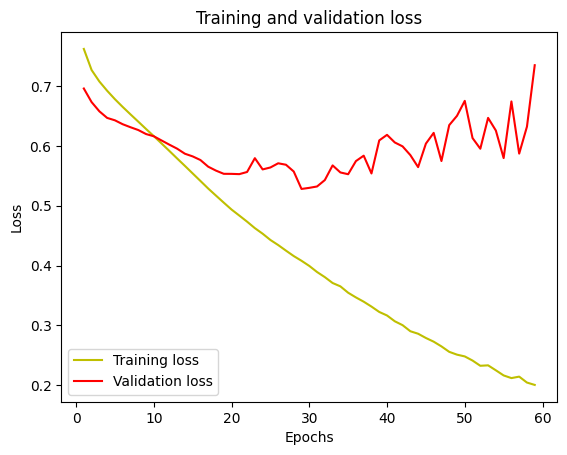

In [25]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

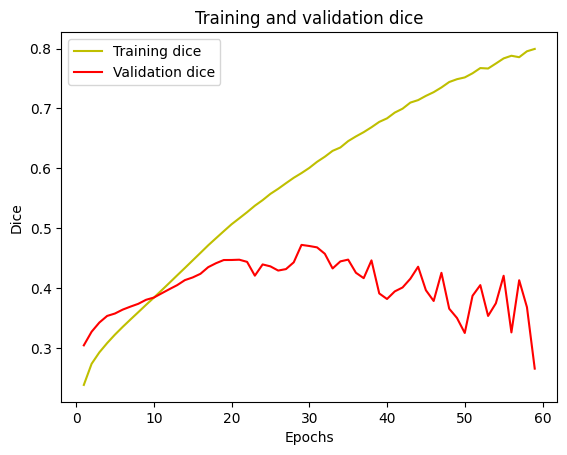

In [26]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [27]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# befoe

In [23]:
model.load_state_dict(torch.load('/home/rabeea/logs/TransAttUnet_polyp/TransAttUNet_polyp_64_msa512_ly5_lr4.pth'))

<All keys matched successfully>

In [24]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
           'train_dice' :train_dices, 'val_dice':val_dices}

In [25]:
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

max training dice:  0.8003643164570843
max validation dice:  0.40925629518926143


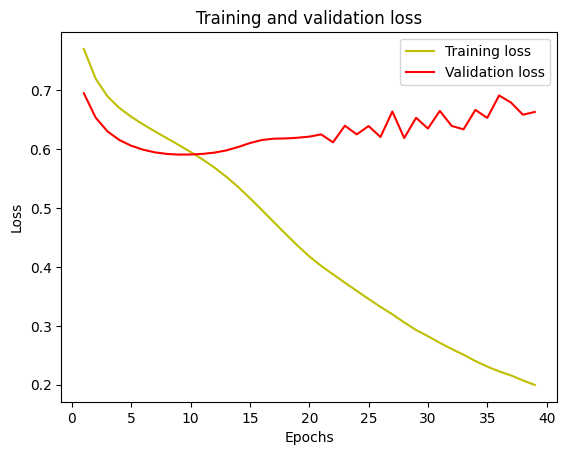

In [26]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

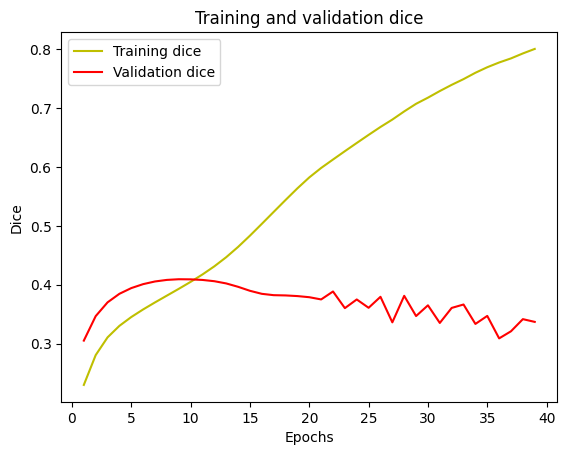

In [27]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [28]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/200 [00:00<?, ?it/s]

Test dice at 0.9:  0.41038559886568693
Test dice at 0.8:  0.45092556670771955
Test dice at 0.7:  0.4676451614585858
Test dice at 0.6:  0.4758389687433555
Test dice at 0.5:  0.4780948986087424
Test dice at 0.4:  0.4753857777736448
Test dice at 0.3:  0.4643426496799111
Test dice at 0.2:  0.43615783449706214
Test dice at 0.1:  0.3615911497827619
Test dice at 0.05:  0.28622339325025675
Test dice at 0.01:  0.2645523125771433


In [29]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(val_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/100 [00:00<?, ?it/s]

Test dice at 0.9:  0.358090548395885
Test dice at 0.8:  0.40188987242250734
Test dice at 0.7:  0.4252277700733248
Test dice at 0.6:  0.44260397387617556
Test dice at 0.5:  0.4602191845681227
Test dice at 0.4:  0.47516227434534813
Test dice at 0.3:  0.4823036028497154
Test dice at 0.2:  0.463520932309184
Test dice at 0.1:  0.39183246817439793
Test dice at 0.05:  0.31296160697937014
Test dice at 0.01:  0.2884260535612702


# f=256, ly=5, lr=-4, msa= 1024

In [24]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
           'train_dice' :train_dices, 'val_dice':val_dices}

In [25]:
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

max training dice:  0.949843521458762
max validation dice:  0.59996102809906


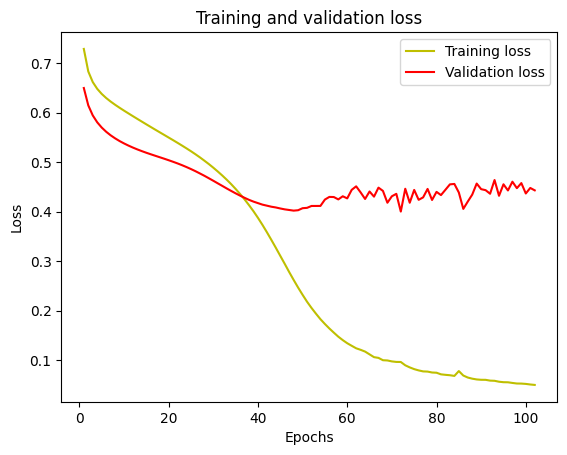

In [26]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

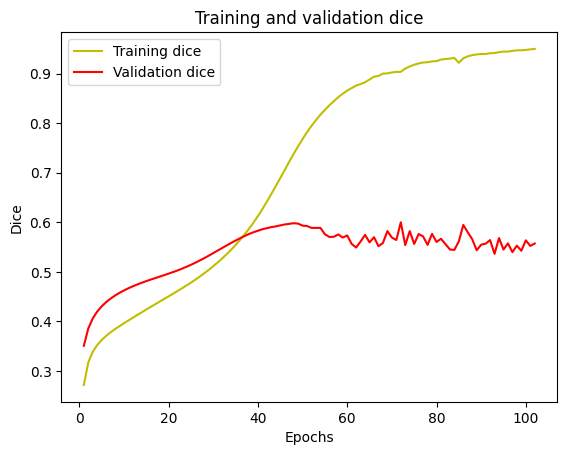

In [27]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [28]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/200 [00:00<?, ?it/s]

Test dice at 0.9:  0.5296002331373892
Test dice at 0.8:  0.5501422758390436
Test dice at 0.7:  0.560754383261774
Test dice at 0.6:  0.5686907472694293
Test dice at 0.5:  0.5751711842221994
Test dice at 0.4:  0.5803907089633867
Test dice at 0.3:  0.5841710408929066
Test dice at 0.2:  0.5863426441677438
Test dice at 0.1:  0.5826966292969155
Test dice at 0.05:  0.5654226247733459
Test dice at 0.01:  0.42407029746100305


In [29]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(val_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/25 [00:00<?, ?it/s]

Test dice at 0.9:  0.5580241537094116
Test dice at 0.8:  0.5862915420532226
Test dice at 0.7:  0.602203985452652
Test dice at 0.6:  0.6131044602394105
Test dice at 0.5:  0.6217989313602448
Test dice at 0.4:  0.6293667709827423
Test dice at 0.3:  0.6354796278476715
Test dice at 0.2:  0.639277229309082
Test dice at 0.1:  0.6373100757598877
Test dice at 0.05:  0.6222970056533813
Test dice at 0.01:  0.48178746104240416


#  64 6ly 

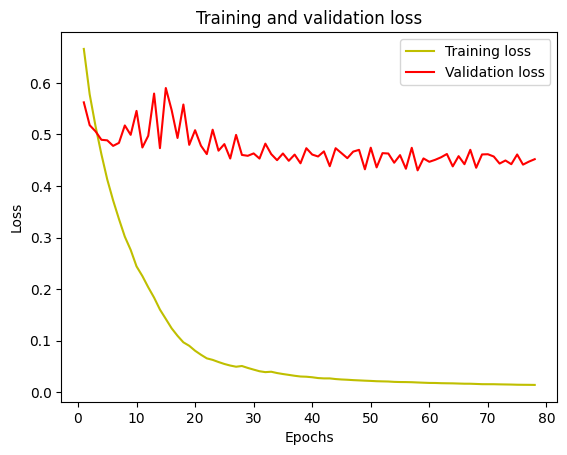

In [23]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

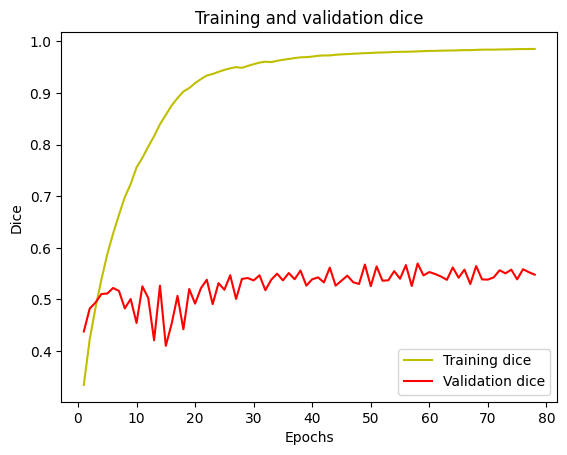

In [24]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [27]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/100 [00:00<?, ?it/s]

Test dice at 0.9:  0.536300193565803
Test dice at 0.8:  0.5479348215921709
Test dice at 0.7:  0.554914331068103
Test dice at 0.6:  0.5602191121397118
Test dice at 0.5:  0.5646708943855993
Test dice at 0.4:  0.5686742879038138
Test dice at 0.3:  0.573102878823811
Test dice at 0.2:  0.5780782469238693
Test dice at 0.1:  0.5838947318822102
Test dice at 0.05:  0.5887803537690343
Test dice at 0.01:  0.5964323818378034


In [28]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(val_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/200 [00:00<?, ?it/s]

Test dice at 0.9:  0.5409751817265714
Test dice at 0.8:  0.5528575050147992
Test dice at 0.7:  0.5600765496883833
Test dice at 0.6:  0.5656992874424759
Test dice at 0.5:  0.5707156797399148
Test dice at 0.4:  0.5756490867214233
Test dice at 0.3:  0.5807728777522425
Test dice at 0.2:  0.5869276884527426
Test dice at 0.1:  0.5951185681095013
Test dice at 0.05:  0.6016556151565237
Test dice at 0.01:  0.6126722214002075


# f=64, ly=4

In [26]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/200 [00:00<?, ?it/s]

Test dice at 0.9:  0.4802949990230991
Test dice at 0.8:  0.4919085319537953
Test dice at 0.7:  0.497411291693752
Test dice at 0.6:  0.5007682623195251
Test dice at 0.5:  0.5025163714216615
Test dice at 0.4:  0.5031219691842853
Test dice at 0.3:  0.5011812826915047
Test dice at 0.2:  0.4955228455428369
Test dice at 0.1:  0.46680803543596994
Test dice at 0.05:  0.4071085895993747
Test dice at 0.01:  0.26527332219760863


In [27]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(val_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/100 [00:00<?, ?it/s]

Test dice at 0.9:  0.4511307885765927
Test dice at 0.8:  0.46447437693928806
Test dice at 0.7:  0.46972262281746224
Test dice at 0.6:  0.47303297567599656
Test dice at 0.5:  0.47448606224486867
Test dice at 0.4:  0.47530229773656174
Test dice at 0.3:  0.4755081494485057
Test dice at 0.2:  0.4743021614728786
Test dice at 0.1:  0.4640714481999021
Test dice at 0.05:  0.42506245171400225
Test dice at 0.01:  0.28969488995149734


# f = 128, ly=5

In [26]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/200 [00:00<?, ?it/s]

Test dice at 0.9:  0.5516217303151462
Test dice at 0.8:  0.5618122291730652
Test dice at 0.7:  0.5677346170827332
Test dice at 0.6:  0.5721131572472768
Test dice at 0.5:  0.5758668304883213
Test dice at 0.4:  0.5793853016982939
Test dice at 0.3:  0.5831964328325557
Test dice at 0.2:  0.5873106572433971
Test dice at 0.1:  0.5931151202879846
Test dice at 0.05:  0.5977720049076015
Test dice at 0.01:  0.6050890164643351


In [27]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(val_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/100 [00:00<?, ?it/s]

Test dice at 0.9:  0.5284268211247399
Test dice at 0.8:  0.5417983718648611
Test dice at 0.7:  0.5499822065384069
Test dice at 0.6:  0.5563204048720946
Test dice at 0.5:  0.5616204808835755
Test dice at 0.4:  0.5668946852438966
Test dice at 0.3:  0.5721124199419865
Test dice at 0.2:  0.5785507637435512
Test dice at 0.1:  0.5873898197611561
Test dice at 0.05:  0.5947049828089803
Test dice at 0.01:  0.6051574447308667


# f=64

In [19]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/200 [00:00<?, ?it/s]

Test dice at 0.9:  0.598983777931935
Test dice at 0.8:  0.5983565549156629
Test dice at 0.7:  0.5965531251209905
Test dice at 0.6:  0.5946735799707676
Test dice at 0.5:  0.5925503258903336
Test dice at 0.4:  0.589954076200629
Test dice at 0.3:  0.5866533948605138
Test dice at 0.2:  0.5821834501958074
Test dice at 0.1:  0.5738754937895646
Test dice at 0.05:  0.5643512984771951
Test dice at 0.01:  0.5251101457686491


In [20]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(train_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/700 [00:00<?, ?it/s]

Test dice at 0.9:  0.7498297855731549
Test dice at 0.8:  0.73937595052154
Test dice at 0.7:  0.731291320387037
Test dice at 0.6:  0.7241851685661199
Test dice at 0.5:  0.7172919376796718
Test dice at 0.4:  0.7099871975742489
Test dice at 0.3:  0.7014720579316261
Test dice at 0.2:  0.6902526450531982
Test dice at 0.1:  0.6715759998921047
Test dice at 0.05:  0.6512797576053084
Test dice at 0.01:  0.5784801606887153


In [21]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(val_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/100 [00:00<?, ?it/s]

Test dice at 0.9:  0.6176958370207285
Test dice at 0.8:  0.6204210188238357
Test dice at 0.7:  0.6204921426622605
Test dice at 0.6:  0.6197640069572663
Test dice at 0.5:  0.6183604755251144
Test dice at 0.4:  0.6161118708922004
Test dice at 0.3:  0.6132410509882902
Test dice at 0.2:  0.6085355719922518
Test dice at 0.1:  0.599662801388331
Test dice at 0.05:  0.5892249627345882
Test dice at 0.01:  0.5504818374486058
